# Solving for the general equilibrium - the Robinson Crusoe economy

Robinson Crusoe, a solitary economist, is simultaneously the consumer and supplier of coconuts, $c$. Ronbinson can sell his labor $l$ which gives him income to buy coconuts. As he also enjoys spending his leisure time relaxing on the beach, he gets negative utility from working. As a consumer, Robinson solves the following problem:

$$
\max_{c,l} = \frac{c^{1-\rho}}{1-\rho} - \eta \frac{l^{1+\nu}}{1+\nu} \\
s.t. \quad c = wl + \pi
$$

where $w$ is Robinson's wage for his labor in the coconut-producing firm (the price of coconuts is normalized to 1), and $\pi$ are the profits he receives.

Robinson's firm converts labor into coconuts using the production function $c=l^\alpha$. The firm problem is therefore:

$$
\max_l \pi \\
s.t. \quad \pi = c - wl \\
\quad \quad c = l^\alpha
$$

Let's find the wage that clears both markets, that is:
1) Robinson's supply of labor is equal to the firm's labor demand
2) Robinson's demand for coconuts is equal to the firm's 

First, we'll import some libraries...

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2

## Partial equilibrium

To find the equilibrium price set, we first nee to solve a smaller, nested problem - namely the partial equilibrium. This involves solving the consumer and producer problem for a fixed set of prices. 

### Consumer problem
Let's start out solving the problem from the perspective of Robinson as a consumer of coconuts and supplier of labor. First, set parameters and define central functions:

In [2]:
par = SimpleNamespace() # SimpleNamespaces are really good for collecting parameters
par.rho = 1.5
par.eta = 0.1
par.nu = 0.33


# consumer:
def utility(c,l, par):
    return c**(1-par.rho)/(1-par.rho) - par.eta*l**(1+par.nu)/(1+par.nu)

def budget_constraint(c, l, w, pi):
    return w*l + pi - c

Next, for a given price $w$ and profits $pi$, we can find Robinson's optimal choice using a constrained maximizer:

In [3]:
# partial equilibrium: find consumer's demand for given wage and profit using a solver
def consumer_optimum(w,pi,par):
    l0 = 0.5
    c0 = w*0.5 

    obj = lambda x: -utility(x[0],x[1], par)            # utility function
    bc = lambda x: budget_constraint(x[0],x[1],w, pi)   # budget constraint
    bounds = [(0,None),(0,None)]                        # must work some and consume some

    c = optimize.minimize(obj, [c0,l0], 
                          constraints={'type':'eq', 'fun': bc},
                          bounds=bounds)
    assert c.success
    return c.x

This gives us Robinson's demand for coconuts and supply of labor as a a function of wages $w$ and profits $\pi$.

Here's a good time to check that the solution works as expected - for instance, we would expect that higher wage would increase the demand for coconuts to increase when wages increase (substitution + income effect).

Let's plot the functions for different values of $w$.

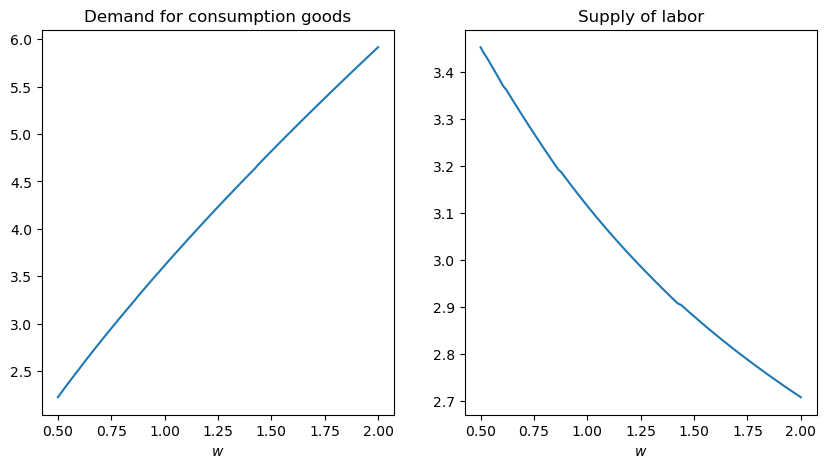

In [4]:
pi = 0.5
w_vals = np.linspace(0.5, 2, 100)
c_vals_w = np.zeros_like(w_vals)
l_vals_w = np.zeros_like(w_vals)
for i, w in enumerate(w_vals):
    c_vals_w[i], l_vals_w[i] = consumer_optimum(w,pi,par)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(w_vals, c_vals_w, label='$c$')
ax[0].set_xlabel('$w$')
ax[0].set_title('Demand for consumption goods')

ax[1].plot(w_vals, l_vals_w, label='$l$')
ax[1].set_xlabel('$w$')
ax[1].set_title('Supply of labor');

This marks the solution of the consumer problem!

### Producer problem
Next, we turn to the production side of the economy. Once again, let's find optimal behavior for a given price $w$. 

Set parameters and define central functions:

In [5]:
par.alpha = 0.67 # let's add production technology to the parameter namespace

# production function
def produce(l, par):
    return l**par.alpha

# firm's profit maximization
def profit(l, w, par):
    return produce(l, par) - w*l

# partial equilibrium: find firm's demand for labor for given wage using a solver
def firm_optimum(w, par):
    l0 = 0.5
    l = optimize.minimize(lambda x: -profit(x, w, par), l0, bounds=[(0,None)])
    assert l.success
    l = l.x[0]

    c = produce(l, par)
    return c, l

This gives producer behavior as a function of wage $w$. Once again, let's just check that the solution makes sense. Labor demand should be decreasing in wages, for instance. 

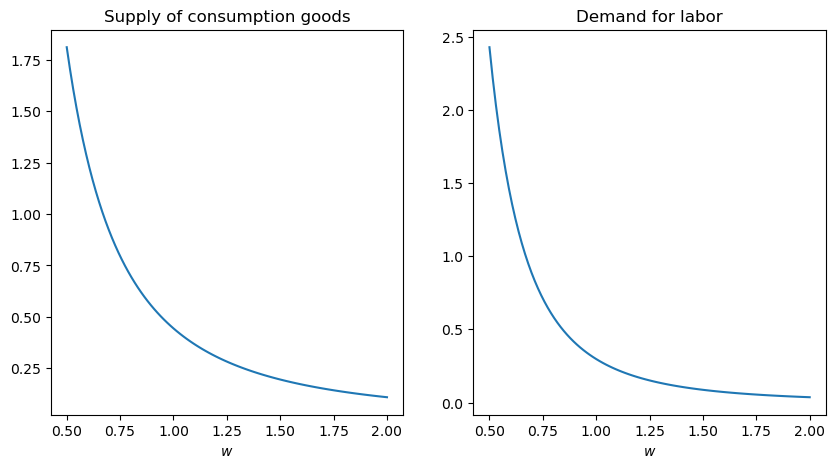

In [6]:
## Let's check that the solution makes sense. Hopefully, the firm's demand for labor and supply of consumption goods is decreasing in w
w_vals = np.linspace(0.5, 2, 100)
c_vals = np.zeros_like(w_vals)
l_vals = np.zeros_like(w_vals)
for i, w in enumerate(w_vals):
    c_vals[i], l_vals[i] = firm_optimum(w,par)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(w_vals, c_vals, label='$c$')
ax[0].set_xlabel('$w$')
ax[0].set_title('Supply of consumption goods')

ax[1].plot(w_vals, l_vals, label='$l$')
ax[1].set_xlabel('$w$')
ax[1].set_title('Demand for labor');

Great, this looks about right - done with the production side!

### Equilibrium prices
Now that we have consumer and producer behavior as a function of prices, it's time to find the price that clears the market. Luckily, Walras' law holds even in small island economies, so we can focus on clearing one market and the other will follow. Let's find the price that clear the labor market.

First, we define a function that measures excess demand:

In [7]:
def excess_labor_demand(w, par):

    # labor supply?
    _, l_dem = firm_optimum(w, par) # firm_optimum returns c and l, we only need l

    # profit?
    pi = profit(l_dem, w, par)

    # labor demand?
    _, l_sup = consumer_optimum(w,pi, par)

    # excess demand?
    return l_dem - l_sup

In equilibrium, the excess labor demand is 0, so let's find the wage taht ensures this.

Since we don't really know what the excess demand function looks like, let's start y doing a coarse grid search to get a rough idea of where the equilibrium is:

In [8]:
wages = np.linspace(0.1, 2, 15)

found_bracket = False
for i,w in enumerate(wages):
    excess = excess_labor_demand(w, par)
    print(f'w = {w:.2f}, excess = {excess:.2f}')

    # save the bracket that contains 0
    if excess < 0 and not found_bracket:
        w_low = wages[i-1]
        w_high = wages[i]
        found_bracket = True

print(f'\nEquilibrium is in interval [{w_low:.2f}, {w_high:.2f}]')

w = 0.10, excess = 318.52
w = 0.24, excess = 23.58
w = 0.37, excess = 3.59
w = 0.51, excess = -1.00
w = 0.64, excess = -2.39
w = 0.78, excess = -2.88
w = 0.91, excess = -3.06
w = 1.05, excess = -3.11
w = 1.19, excess = -3.11
w = 1.32, excess = -3.08
w = 1.46, excess = -3.04
w = 1.59, excess = -3.00
w = 1.73, excess = -2.95
w = 1.86, excess = -2.90
w = 2.00, excess = -2.86

Equilibrium is in interval [0.37, 0.51]


We can find the market clearing price by using a root finding algorithm.

In [9]:
w_eq = optimize.brentq(excess_labor_demand, w_low, w_high, args=(par,)) # optimize.brentq is a root finding algorithm that works well for continuous functions in 1 dimension
print(f'Equilibrium wage: {w_eq:.2f}')

Equilibrium wage: 0.46


Finally, let's verify that both markets clear.

In [10]:
c_sup, l_dem = firm_optimum(w_eq, par)
pi_eq = profit(l_dem, w_eq, par)
c_dem, l_sup = consumer_optimum(w_eq, pi_eq, par)

print(f'Coconuts: supply = {c_sup:.2f}, demand = {c_dem:.2f}')
print(f'Labor: demand = {l_dem:.2f}, supply = {l_sup:.2f}')

Coconuts: supply = 2.15, demand = 2.15
Labor: demand = 3.14, supply = 3.14


This looks right! 

## Cleaning it all up...

In the above notebook, the code is written ad hoc, as we get to the relevant parts of the problem in question. This is to make it clear how to approach equilibrium problems. However, for assignments etc. we should probably clean up a bit.

Now that we know that our code works, let's collect it in a user defined module to keep everything tidy and contained.

The module robinson_economy contains a class that does the exact same - but the code is contained in the module and the notebook is clean.

In [12]:
from robinson_economy import RobinsonModel

model = RobinsonModel()
model.find_equilibrium_wage(w_low=0.1, w_high=2)

print(f'\nEquilibrium coconuts: {model.sol.c_eq:.2f}')
print(f'Equilibrium labor: {model.sol.l_eq:.2f}')

w = 0.10, excess = 318.52
w = 0.24, excess = 23.58
w = 0.37, excess = 3.59
w = 0.51, excess = -1.00
w = 0.64, excess = -2.39
w = 0.78, excess = -2.88
w = 0.91, excess = -3.06
w = 1.05, excess = -3.11
w = 1.19, excess = -3.11
w = 1.32, excess = -3.08
w = 1.46, excess = -3.04
w = 1.59, excess = -3.00
w = 1.73, excess = -2.95
w = 1.86, excess = -2.90
w = 2.00, excess = -2.86

Equilibrium wage: 0.46

Equilibrium coconuts: 2.15
Equilibrium labor: 3.14
